# Supervised Machine Learning Techniques for Anamaly Detection

### Random Forest and Gradient Boosting 

Anderson Nelson  <br>
Date: 11/17/2019 <br>

### Introduction

In this exercise, I will walk you through my approach to create a model to identify fraud in financial transaction data. I will cover data preparing the data and train two different model Random Forest and a Gradient Boosting model and optimize the performance by tuning the parameters.  

In [1]:
import numpy as np
import datetime
import h2o 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore')

In [2]:
def VarImp(model_name):    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
def createGains(model, test_hex):
    predictions = model.predict(test_hex)
    
    predictions = predictions.as_data_frame()
    test_hex = test_hex.as_data_frame()

    test_hex['loan_default'] = np.where(test_hex['loan_default'] == 'No', 0,1)
    predictions['predict'] = np.where(predictions['predict'] == 'No',0,1)

    test_scores = pd.concat([predictions['predict'],test_hex['loan_default']], axis=1)


    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)


def ROC_AUC(my_result,df,target):
    
    y_pred = my_result.predict(df).as_data_frame()
    df = df.as_data_frame()
    df[target] = np.where(df[target] == 'No', 0,1)
    # ROC
    y_actual = df[target]
    
    y_pred['predict'] = np.where(y_pred['predict'] == 'No', 0,1)
    
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred['predict'])
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred['predict'])

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(9,6))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred['predict'])
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()
    

def plot_auc(model):
    plt.figure(figsize=(9,6))
    plt.plot(model.roc()[0],model.roc()[1],color='darkorange',lw=2)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic: AUC={model.auc():0.4f}')
    plt.show()
    
def column_scaler(data): 
    data_scaler = StandardScaler()
    for value in data.columns: 
        testing_data = pd.DataFrame(data.loc[:,value])
        data.loc[:,value] = data_scaler.fit_transform(testing_data)
        return data

In [3]:
# read data 
data = pd.read_csv('../Data/XYZloan_default_selected_vars.csv')

# drop neccessary columns 
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

The first thing i wanted to do is check whether the data contains any duplicate id.

In [4]:
# are there any duplicated id 
sum(data.id.duplicated())

0

The first step to an analysis is to understand the data. Lets start with understanding how missing values.

In [5]:
f'{round(sum(data.isna().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is missing'

'9.0% of the data is missing'

In [6]:
f'{round(sum(data.isnull().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is null'

'9.0% of the data is null'

The number of missing values represents a small percentage of the dataset. However, those values shouldn’t be ignored. There are a number of different strategies to deal with missing values.

    1. Imputation
    2. Deletion

Exploring the colums with missing data will allow us to determine the best strategy to solve the missing data problem.

In [7]:
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)

The graph shows us that there are a few collumn where more than 99% of the data is missing or null

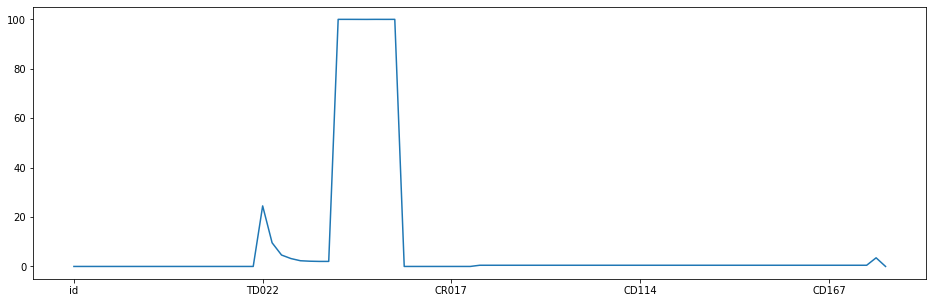

In [8]:
fig = plt.figure(figsize=(16,5))
col_missing.plot()
plt.show()

In [9]:
col_missing[col_missing > 99]

TD044    100.00
TD048    100.00
TD051     99.99
TD054     99.98
TD055    100.00
TD061     99.99
TD062    100.00
dtype: float64

We will remove those columns since 

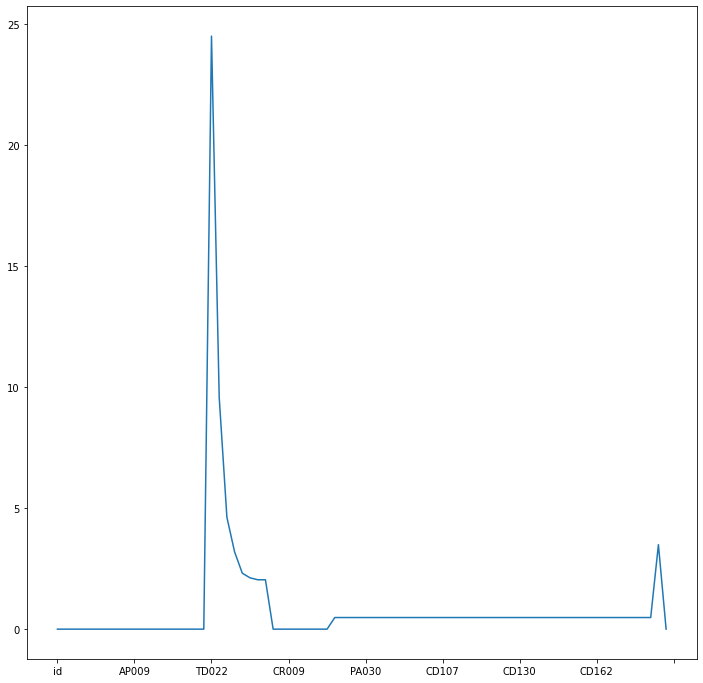

In [10]:
data = data.drop(columns=col_missing[col_missing > 99].index)
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)
fig = plt.figure(figsize=(12,12))
col_missing.plot()
plt.show()

A few users represent the missing values in the data; after further analysis, it seems that missing patterns exist from a distinct group of users. The columns that have missing values also follow a pattern; they are all related to the phone. There are several reasons why that column could be missing: but the most likely reason is that those people don’t have a phone number, or it was never provided to the company.

The best option is to either remove them from the data or impute with 0. If we exclude from the data, a small but essential segment of our population could be misrepresented; on the contrary, if we include it could potentially skew the analysis since we assumed the missing values.

However, inputting the values with 0 makes the most sense for this data since, given that the users do not have a phone, the bank would be unable to call, leave voicemails and converse with the client, which is fair.

In [11]:
col_missing.sort_values(ascending=False)

TD022    24.50
TD023     9.58
TD024     4.62
MB005     3.49
TD025     3.19
         ...  
CR015     0.00
CR017     0.00
CR018     0.00
CR019     0.00
id        0.00
Length: 80, dtype: float64

In [12]:
data = data.fillna(0)

The MB007 column contains many categorical values. I discovered that the top 9 values contribute to over 90% of the distribution. I gave the other categories the value of 'Other'. 

In [13]:
MB007_value_count = pd.DataFrame(data.MB007.value_counts())
MB007_value_count['cum_sum'] = MB007_value_count.cumsum()
MB007_value_count['%'] = MB007_value_count['cum_sum'] / 80000
MB007_value_count = MB007_value_count.drop(index='Noinfo')

In [14]:
data['MB007'] = data['MB007'].apply(lambda i: i if i in MB007_value_count[1:10].index else 'Other')

Since the values in column MBOO7 and AP006 are not ordinal, to prevent the model from assigning a higher value to the categorical data. I will One hot encode the variables 

In [15]:
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.MB007)], axis=1)
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.AP006)], axis=1)
data = data.drop(columns=['MB007','AP006'])

After searching throughout the entire model for abnormalities, I found that the are numerous -99 value, which is another form of Null recorded. A small number of users have a considerable proportion of 99 values in their records. Those users can skew the model results, and I remove them.

In [16]:
# how many -99 values per user id 
user_list_99 = []
for row in range(0, len(data)):
    row_data = data.iloc[row]
    user_list_99.append(list(row_data).count(-99))

In [17]:
_99_count= pd.DataFrame({'id': data.iloc[:,0],
             '99_count' : user_list_99})

In [18]:
# how many id have more than 1 -99 values and how many 99 values exsist 
_99_count[_99_count['99_count'] > 0]
_99_count[_99_count['99_count'] > 0]['99_count'].value_counts()

36    1773
42    1534
Name: 99_count, dtype: int64

In [19]:
f'{round((len(_99_count[_99_count["99_count"] > 0]["99_count"]) / len(data)) * 100,2)}% of users have more than 36 values labels as -99 in their respective row'

'4.13% of users have more than 36 values labels as -99 in their respective row'

In [20]:
# remove the ids with -99 values 
_99_count[_99_count['99_count'] > 0]['id'].values
data = data[~data.iloc[:,0].isin(_99_count[_99_count['99_count'] > 0]['id'].values)].reset_index()

Lastly, I found that the date variable had predictive power in my model, However, it doesn't make sense to include in my model. 

In [21]:
# covert AP005 into date and time 
data = data.drop(columns='AP005')

Convert 0 = No and 1 = Yes in the default

In [22]:
# convert the loan_faults into categerical 
data['loan_default'] = np.where(data['loan_default'] == 0, 'No','Yes')

#### Standardized valriables: 

The dataset contains features highly varying in magnitudes, units and range. Since, most of the machine learning algorithms use Eucledian distance between two data points in their computations this could potential be a problem if not addressed.

However, Tree based models are not distance based models and can handle varying ranges of features. I elected not to scale my variables since while modelling trees.

In [23]:
clean_data= data.drop(columns=['index', 'id'])

In [24]:
train, test = train_test_split(
    clean_data, test_size=0.30, random_state=23)

target = 'loan_default'
predictors = train.columns[1:]

In [25]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.9+7-LTS, mixed mode)
  Starting server from C:\Users\ander\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ander\AppData\Local\Temp\tmppi1yn22e
  JVM stdout: C:\Users\ander\AppData\Local\Temp\tmppi1yn22e\h2o_ander_started_from_python.out
  JVM stderr: C:\Users\ander\AppData\Local\Temp\tmppi1yn22e\h2o_ander_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_ander_inxbic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.955 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [26]:
# full data
train_full = h2o.H2OFrame(train)
test_full = h2o.H2OFrame(test)

# sample data to test 
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Model 1: 

As a first step, i'll build a test models to measure performance against. Given that we have an ubalanced dataset I'm goint to used balance_classes = True, and stopping metric of AUCPR. 

The main difference between AUC and AUCPR is that AUC calculates the area under the ROC curve and AUCPR calculates the area under the Precision Recall curve. The Precision Recall curve does not care about True Negatives. For imbalanced data, a large quantity of True Negatives usually overshadows the effects of changes in other metrics like False Positives. The AUCPR will be much more sensitive to True Positives, False Positives, and False Negatives than AUC. As such, AUCPR is recommended over AUC for highly imbalanced data.


I'm using more than enough trees to train the preliminary model, however I've implemented early stopping if the models isn't improving as measured by the AUCPR after 5 consecutive attempts 

In [27]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        max_depth = 10,
        ntrees = 900,
        balance_classes = True, 
        stopping_rounds = 5, 
        stopping_tolerance = 1e-4, stopping_metric = "AUCPR",  
        nfolds=10,
        min_rows=100,
        seed=1234)

In [28]:
rf_v1.train(list(predictors),target,training_frame=train_hex,validation_frame=test_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
rf_v1_test = rf_v1.model_performance(test_hex)

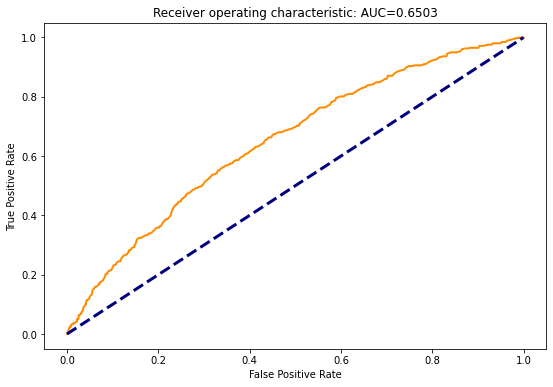

In [30]:
plot_auc(rf_v1_test)

In [31]:
rf_v1_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.86 %, avg score: 17.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010430,0.346021,2.097921,2.097921,0.416667,0.369172,0.416667,0.369172,0.021882,0.021882,109.792123,109.792123,0.014290
1,2,0.020426,0.323931,1.532395,1.821174,0.304348,0.334157,0.361702,0.352037,0.015317,0.037199,53.239463,82.117417,0.020930
2,3,0.030422,0.313506,1.532395,1.726289,0.304348,0.318844,0.342857,0.341131,0.015317,0.052516,53.239463,72.628947,0.027571
3,4,0.040417,0.302266,2.189135,1.840757,0.434783,0.308324,0.365591,0.333017,0.021882,0.074398,118.913519,84.075669,0.042403
4,5,0.050413,0.295147,2.189135,1.909832,0.434783,0.298350,0.379310,0.326144,0.021882,0.096280,118.913519,90.983174,0.057235
5,6,0.100391,0.266725,1.707525,1.809116,0.339130,0.278830,0.359307,0.302589,0.085339,0.181619,70.752545,80.911649,0.101359
6,7,0.150369,0.245460,1.619960,1.746247,0.321739,0.254556,0.346821,0.286625,0.080963,0.262582,61.996004,74.624657,0.140022
7,8,0.200348,0.229073,1.357264,1.649212,0.269565,0.236504,0.327549,0.274122,0.067834,0.330416,35.726382,64.921183,0.162303
8,9,0.300304,0.206303,1.335372,1.544750,0.265217,0.217147,0.306802,0.255157,0.133479,0.463895,33.537247,54.475010,0.204134
9,10,0.400261,0.189637,1.116459,1.437794,0.221739,0.197705,0.285559,0.240810,0.111597,0.575492,11.645895,43.779357,0.218659


In [32]:
# prescion recall curve
rf_v1_test.pr_auc()

0.30053253109615724

### Model 2:
I'm going to focus on optimizing the precision-recall curve and lift. The models performed better than a random guess as indicated by the gains table, and it performed terribly on the precision-recall curve. 

Max_depth is one of the most powerful levers that tends to increase the predictive power of a random forest model. For the second, I want to see if decreasing max depth to the default values improves the model performance. 


In [33]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 900,
        balance_classes = True, 
        stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUCPR",
        nfolds=10,
        min_rows=100,
        seed=1234)

rf_v2.train(list(predictors),target,training_frame=train_hex,validation_frame=test_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [34]:
rf_v2_test = rf_v2.model_performance(test_data=test_hex)

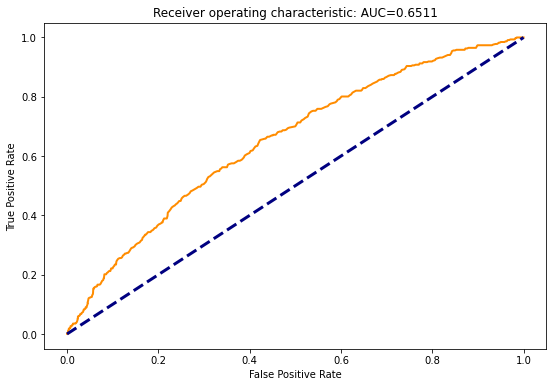

In [35]:
plot_auc(rf_v2_test)

In [36]:
# precision recall 
rf_v2_test.pr_auc()

0.2994105829923784

In [37]:
rf_v2_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.86 %, avg score: 17.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010430,0.350407,2.097921,2.097921,0.416667,0.373158,0.416667,0.373158,0.021882,0.021882,109.792123,109.792123,0.014290
1,2,0.020426,0.326836,1.313481,1.714046,0.260870,0.336195,0.340426,0.355070,0.013129,0.035011,31.348112,71.404628,0.018200
2,3,0.030422,0.314355,2.189135,1.870147,0.434783,0.319958,0.371429,0.343533,0.021882,0.056893,118.913519,87.014692,0.033032
3,4,0.040417,0.305149,1.532395,1.786617,0.304348,0.308693,0.354839,0.334917,0.015317,0.072210,53.239463,78.661679,0.039672
4,5,0.050413,0.297025,1.751308,1.779616,0.347826,0.300695,0.353448,0.328132,0.017505,0.089716,75.130815,77.961594,0.049043
5,6,0.100391,0.265981,1.926439,1.852710,0.382609,0.279585,0.367965,0.303963,0.096280,0.185996,92.643897,85.270965,0.106820
6,7,0.150369,0.244936,1.576177,1.760799,0.313043,0.254206,0.349711,0.287426,0.078775,0.264770,57.617734,76.079862,0.142753
7,8,0.200348,0.229088,1.269698,1.638290,0.252174,0.237019,0.325380,0.274851,0.063457,0.328228,26.969841,63.828989,0.159572
8,9,0.300304,0.206553,1.379155,1.552037,0.273913,0.217127,0.308249,0.255638,0.137856,0.466083,37.915517,55.203666,0.206864
9,10,0.400261,0.189723,1.072676,1.432327,0.213043,0.197732,0.284473,0.241177,0.107221,0.573304,7.267624,43.232667,0.215929


## Model 3: 

Hyperparameter Tuning is one of the most exciting aspects of training machine learning models, and its searching for the right set of hyperparameters to achieve high precision and accuracy.

The primary aim of hyperparameter tuning is to find the sweet spot for the model's parameters to achieve the best performance.

There are ways to test how different hyperparameters impact the performance of the model: two of the most popular techniques are grid search and random search. 

- Grid search: Try every combination of a preset list of values of the hyper-parameters and evaluate the model for each combination. Brute force approach. 
- Random search: A technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values.

I found that random search performs better than grid search. While an exhaustive grid search might give be the absolute optimal values, I have generally found the incremental gain in performance isn't worth the computational cost. 

In [38]:
rf_v3 = H2ORandomForestEstimator(nfolds = 5,seed = 1234,balance_classes = True)

hyper_params = {'max_depth': [0,5,10,20,30],
                 'ntrees': [200,500,700,900]}

rf_grid = H2OGridSearch(model = rf_v3, hyper_params = hyper_params,
                     search_criteria = {'strategy': "RandomDiscrete",'max_models': 36, 
                                        'seed': 1,"stopping_metric": "AUCPR",
                                        "stopping_tolerance": 0.05, 
                                        "stopping_rounds": 3})

In [39]:
rf_grid.train(x = list(predictors), y = target, training_frame=train_hex,validation_frame=test_hex)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [40]:
# Get the grid results, sorted by validation AUC
rf_grid = rf_grid.get_grid(sort_by='recall', decreasing=True)

In [41]:
rf_grid= rf_grid.models[0]

In [42]:
rf_grid_test = rf_grid.model_performance(test_hex)

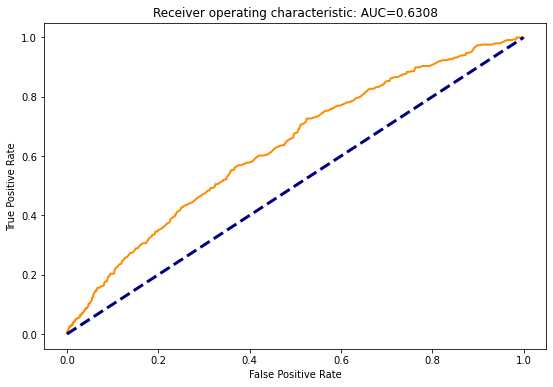

In [43]:
plot_auc(rf_grid_test)

In [44]:
rf_grid_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.86 %, avg score:  8.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010430,0.238466,2.517505,2.517505,0.500000,0.265539,0.500000,0.265539,0.026258,0.026258,151.750547,151.750547,0.019751
1,2,0.020426,0.214678,1.532395,2.035430,0.304348,0.227527,0.404255,0.246937,0.015317,0.041575,53.239463,103.542995,0.026391
2,3,0.030422,0.197531,1.313481,1.798218,0.260870,0.203139,0.357143,0.232546,0.013129,0.054705,31.348112,79.821819,0.030301
3,4,0.040417,0.185902,1.532395,1.732477,0.304348,0.190774,0.344086,0.222216,0.015317,0.070022,53.239463,73.247688,0.036942
4,5,0.050413,0.177120,1.751308,1.736211,0.347826,0.181741,0.344828,0.214190,0.017505,0.087527,75.130815,73.621067,0.046313
5,6,0.100391,0.147151,1.707525,1.721930,0.339130,0.160846,0.341991,0.187634,0.085339,0.172867,70.752545,72.193015,0.090437
6,7,0.150369,0.132961,1.576177,1.673486,0.313043,0.139581,0.332370,0.171662,0.078775,0.251641,57.617734,67.348630,0.126370
7,8,0.200348,0.120822,1.138350,1.539993,0.226087,0.125943,0.305857,0.160257,0.056893,0.308534,13.835030,53.999250,0.134998
8,9,0.300304,0.103172,1.291590,1.457311,0.256522,0.112095,0.289436,0.144227,0.129103,0.437637,29.158976,45.731142,0.171368
9,10,0.400261,0.090194,1.160242,1.383125,0.230435,0.097008,0.274701,0.132435,0.115974,0.553611,16.024165,38.312461,0.191355


In [45]:
# precision recall curve
rf_grid_test.pr_auc()

0.2923433856037176

Final Model: test the best performing model on the entire data set 

The best performing model is model 2. Lets test it on the entire dataset 

In [46]:
rf_v2.train(x = list(predictors), y = target, training_frame=train_full,validation_frame=test_full)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [47]:
rf_v2_test = rf_grid.model_performance(test_full)

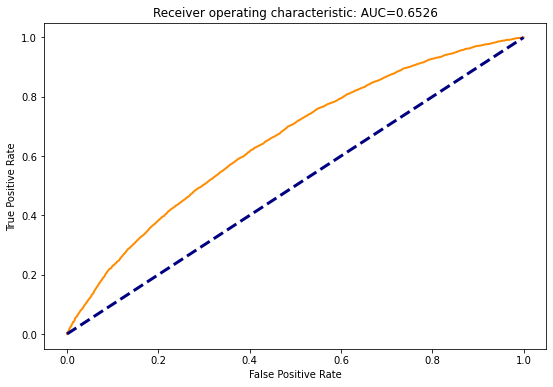

In [48]:
plot_auc(rf_v2_test)

In [49]:
rf_v2_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.29 %, avg score:  8.53 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,0.237096,2.243788,2.243788,0.432900,0.273273,0.432900,0.273273,0.022528,0.022528,124.378760,124.378760,0.015473
1,2,0.020037,0.208678,1.938047,2.091249,0.373913,0.221685,0.403471,0.247535,0.019374,0.041901,93.804715,109.124898,0.027092
2,3,0.030033,0.192036,1.960583,2.047757,0.378261,0.200058,0.395080,0.231732,0.019599,0.061500,96.058258,104.775655,0.038990
3,4,0.040030,0.181844,1.847905,1.997848,0.356522,0.186642,0.385451,0.220472,0.018473,0.079973,84.790542,99.784802,0.049492
4,5,0.050026,0.173792,1.802835,1.958879,0.347826,0.177564,0.377932,0.211898,0.018022,0.097995,80.283456,95.887921,0.059436
5,6,0.100009,0.147006,1.816356,1.887648,0.350435,0.158829,0.364189,0.185375,0.090786,0.188781,81.635582,88.764848,0.109994
6,7,0.150035,0.131816,1.544588,1.773262,0.298002,0.138916,0.342121,0.169884,0.077270,0.266051,54.458752,77.326170,0.143750
7,8,0.200017,0.120230,1.361140,1.670276,0.262609,0.125666,0.322251,0.158835,0.068033,0.334084,36.114009,67.027608,0.166116
8,9,0.300026,0.102237,1.252425,1.530993,0.241634,0.110920,0.295379,0.142863,0.125253,0.459338,25.242549,53.099255,0.197396
9,10,0.400035,0.088851,1.124029,1.429252,0.216862,0.095484,0.275750,0.131018,0.112413,0.571750,12.402935,42.925175,0.212765


In [50]:
rf_v2_test.pr_auc()

0.29798664698148614

### Gradient Boosting

I train a GBM with parameters. Iuse early stopping to automatically tune the number of trees using the validation AUC. I also use a lower learning rate, and stochastic sampling of rows and columns to improve generalization. I use this first model to benchmark peformance against. 

### Model 1 

The first model with random paramaters performs slightly better than the optimized random forest model.  

In [51]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        nfolds = 10,
        ntrees = 10000,
        learn_rate = 0.01,
        stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUCPR",
        sample_rate = 0.8,
        balance_classes = True,
        col_sample_rate = 0.8,
        score_tree_interval = 10,
        seed=9181)

In [52]:
gbm_v1.train(list(predictors),target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
gbm_v1_test = gbm_v1.model_performance(test_hex)

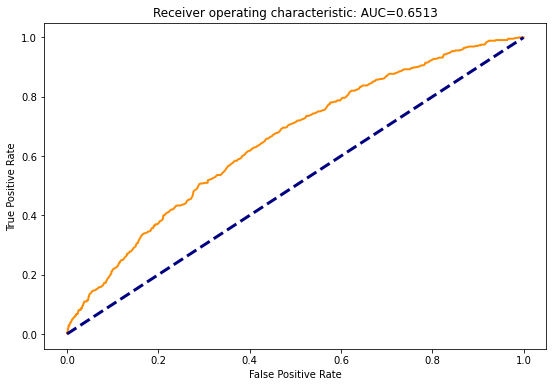

In [54]:
plot_auc(gbm_v1_test)

In [55]:
gbm_v1_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.86 %, avg score: 17.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010430,0.345432,2.937090,2.937090,0.583333,0.365455,0.583333,0.365455,0.030635,0.030635,193.708972,193.708972,0.025212
1,2,0.020426,0.327786,2.189135,2.571069,0.434783,0.335198,0.510638,0.350648,0.021882,0.052516,118.913519,157.106942,0.040044
2,3,0.030422,0.314148,1.532395,2.229791,0.304348,0.321749,0.442857,0.341153,0.015317,0.067834,53.239463,122.979056,0.046684
3,4,0.040417,0.298944,1.532395,2.057316,0.304348,0.306206,0.408602,0.332510,0.015317,0.083151,53.239463,105.731630,0.053325
4,5,0.050413,0.290560,2.408049,2.126858,0.478261,0.294207,0.422414,0.324915,0.024070,0.107221,140.804871,112.685807,0.070887
5,6,0.100391,0.260184,1.313481,1.721930,0.260870,0.274371,0.341991,0.299753,0.065646,0.172867,31.348112,72.193015,0.090437
6,7,0.150369,0.238723,1.663743,1.702590,0.330435,0.248534,0.338150,0.282729,0.083151,0.256018,66.374275,70.259040,0.131831
7,8,0.200348,0.225043,1.619960,1.681978,0.321739,0.231680,0.334056,0.269994,0.080963,0.336980,61.996004,68.197762,0.170494
8,9,0.300304,0.204844,1.116459,1.493744,0.221739,0.214701,0.296671,0.251590,0.111597,0.448578,11.645895,49.374420,0.185020
9,10,0.400261,0.187003,1.225916,1.426860,0.243478,0.195892,0.283388,0.237681,0.122538,0.571116,22.591571,42.685978,0.213198


In [56]:
gbm_v1_test.pr_auc()

0.3127802362941372

### Model 2

Next, we'll do real hyper-parameter optimization to see if we can beat the best prescision recall.

The key here is to start tuning some key parameters first (i.e., those that we expect to have the biggest impact on the results). From experience with gradient boosted trees across many datasets, we can state the following "rules":

1. Build as many trees (ntrees) as it takes until the validation set error starts increasing.
2. A lower learning rate (learn_rate) is generally better, but will require more trees. Using learn_rate=0.02and learn_rate_annealing=0.995 (reduction of learning rate with each additional tree) can help speed up convergence without sacrificing accuracy too much, and is great to hyper-parameter searches. For faster scans, use values of 0.05 and 0.99 instead.
  
3. The optimum maximum allowed depth for the trees (max_depth) is data dependent, deeper trees take longer to train, especially at depths greater than 10.
4. Row and column sampling (sample_rate and col_sample_rate) can improve generalization and lead to lower validation and test set errors. Good general values for large datasets are around 0.7 to 0.8 (sampling 70-80 percent of the data) for both parameters. Column sampling per tree (col_sample_rate_per_tree) can also be tuned. Note that it is multiplicative with col_sample_rate, so setting both parameters to 0.8 results in 64% of columns being considered at any given node to split.
5. For highly imbalanced classification datasets, stratified row sampling based on response class membership can help improve predictive accuracy. It is configured with sample_rate_per_class (array of ratios, one per response class in lexicographic order).
6. Most other options only have a small impact on the model performance, but are worth tuning with a Random hyper-parameter search nonetheless, if highest performance is critical.


In [57]:
hyper_params_tune = {'max_depth' : list(range(12,30+1,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  
                   'max_models': 20,  
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUCPR",
                   'stopping_tolerance': 1e-3
                   }

In [58]:
gbm_grid_v1 = H2OGradientBoostingEstimator(
                    ntrees=10000,
                    learn_rate=0.01,
                    learn_rate_annealing = 0.99,
                    score_tree_interval = 10,
                    seed = 1234,
                    stopping_rounds = 5,
                    stopping_metric = "AUCPR",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
gbm_v2 = H2OGridSearch(gbm_grid_v1, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)

In [59]:
gbm_v2.train(list(predictors),target,training_frame=train_hex)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [60]:
sorted_gbm_v2 = gbm_v2.get_grid(sort_by='recall',decreasing=True)
print(sorted_gbm_v2)

     col_sample_rate col_sample_rate_change_per_level  \
0               0.29                             1.07   
1               0.25                             0.97   
2               0.71                             1.01   
3                0.8                             0.93   
4               0.76                             0.93   
5               0.68                              1.1   
6               0.31                             0.99   
7               0.52                             1.06   
8               0.22                             0.92   
9               0.73                             1.06   
10              0.61                             1.09   
11              0.63                             1.06   
12              0.66                              0.9   
13              0.25                             1.07   
14              0.63                             1.08   
15              0.34                             0.93   
16              0.64           

In [61]:
gbm_v2_top_model = sorted_gbm_v2.models[0]

In [62]:
gbm_v2_test = gbm_v2_top_model.model_performance(test_data=test_hex)

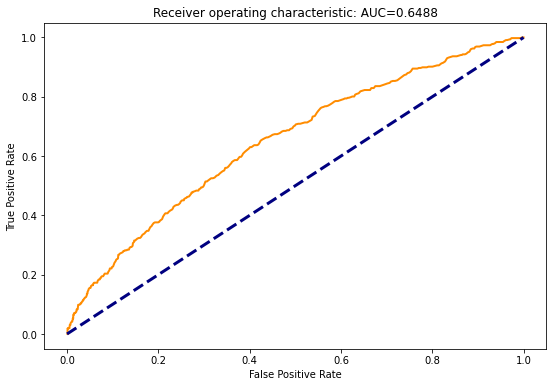

In [63]:
plot_auc(gbm_v2_test)

In [64]:
gbm_v2_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.86 %, avg score: 17.92 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010430,0.363508,2.727298,2.727298,0.541667,0.401284,0.541667,0.401284,0.028446,0.028446,172.729759,172.729759,0.022481
1,2,0.020426,0.334480,2.408049,2.571069,0.478261,0.345257,0.510638,0.373867,0.024070,0.052516,140.804871,157.106942,0.040044
2,3,0.030422,0.314899,1.970222,2.373648,0.391304,0.323455,0.471429,0.357303,0.019694,0.072210,97.022167,137.364802,0.052145
3,4,0.040417,0.302893,2.626962,2.436296,0.521739,0.307659,0.483871,0.345025,0.026258,0.098468,162.696223,143.629562,0.072438
4,5,0.050413,0.293607,1.532395,2.257074,0.304348,0.297665,0.448276,0.335635,0.015317,0.113786,53.239463,125.707387,0.079078
5,6,0.100391,0.256825,1.619960,1.939896,0.321739,0.273937,0.385281,0.304920,0.080963,0.194748,61.996004,93.989599,0.117742
6,7,0.150369,0.238508,1.576177,1.819007,0.313043,0.247476,0.361272,0.285827,0.078775,0.273523,57.617734,81.900684,0.153675
7,8,0.200348,0.223743,1.269698,1.681978,0.252174,0.230634,0.334056,0.272059,0.063457,0.336980,26.969841,68.197762,0.170494
8,9,0.300304,0.200258,1.225916,1.530177,0.243478,0.212206,0.303907,0.252137,0.122538,0.459519,22.591571,53.017699,0.198673
9,10,0.400261,0.182405,1.116459,1.426860,0.221739,0.191152,0.283388,0.236907,0.111597,0.571116,11.645895,42.685978,0.213198


In [65]:
gbm_v2_test.pr_auc()

0.31980537280486393

The best model was the first model with random values intialized  lets train it on the full model

In [ ]:
gbm_v1.train(list(predictors),target,training_frame=train_full, validation_frame=test_full)

gbm Model Build progress: |████████████

Concusion: 

- All paramters are not created equal. Certain parameters have greater impact on model performance. 
- Early stopping is a great to stop running models if performance isn't improving 
- Understanding your data and cleaning data, can dramatatically improve performance. 
- In both examples the best model was where the hyperamaters were random